In [57]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV

In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Load dataset
data = pd.read_csv("/content/drive/MyDrive/HR-Employee-Attrition.csv")

In [37]:
# Inspect the data
print("Dataset shape:", data.shape)
print(data.info())
print(data.head())

Dataset shape: (1470, 35)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14

In [38]:
# Summary statistics for numeric features
print(data.describe())

# Count of categorical features
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nValue counts for {col}:")
    print(data[col].value_counts())


               Age    DailyRate  DistanceFromHome    Education  EmployeeCount  \
count  1470.000000  1470.000000       1470.000000  1470.000000         1470.0   
mean     36.923810   802.485714          9.192517     2.912925            1.0   
std       9.135373   403.509100          8.106864     1.024165            0.0   
min      18.000000   102.000000          1.000000     1.000000            1.0   
25%      30.000000   465.000000          2.000000     2.000000            1.0   
50%      36.000000   802.000000          7.000000     3.000000            1.0   
75%      43.000000  1157.000000         14.000000     4.000000            1.0   
max      60.000000  1499.000000         29.000000     5.000000            1.0   

       EmployeeNumber  EnvironmentSatisfaction   HourlyRate  JobInvolvement  \
count     1470.000000              1470.000000  1470.000000     1470.000000   
mean      1024.865306                 2.721769    65.891156        2.729932   
std        602.024335            

In [39]:
# Check for missing values
print("Missing values per column:")
print(data.isnull().sum())


Missing values per column:
Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurren

In [40]:
# Dropping Columns that are unnecessary
cols_to_drop = ['EmployeeNumber', 'EmployeeCount', 'StandardHours', 'Over18']
data = data.drop(columns=cols_to_drop)
print("Columns after dropping:", data.columns)


Columns after dropping: Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')


In [41]:
# Binary features
binary_cols = ['Attrition', 'OverTime']

# Multi-class categorical features
multi_cat_cols = ['BusinessTravel', 'Department', 'EducationField',
                  'Gender', 'JobRole', 'MaritalStatus']

# Encode binary manually (since LabelEncoder is fine here)
data['Attrition'] = data['Attrition'].map({'Yes':1, 'No':0})
data['OverTime'] = data['OverTime'].map({'Yes':1, 'No':0})

# Numeric features
numeric_cols = data.select_dtypes(include='number').columns.tolist()
numeric_cols.remove('Attrition')  # remove target if in numeric list
print(numeric_cols)


# ColumnTransformer for one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', sparse_output=False), multi_cat_cols)
        # numeric columns can be scaled later if needed
    ],
    remainder='passthrough'  # keep other columns as-is
)

# Apply transformation
data_transformed = preprocessor.fit_transform(data.drop('Attrition', axis=1))

# Convert back to DataFrame with proper column names
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(multi_cat_cols)
all_cols = list(encoded_cols) + [col for col in data.drop('Attrition', axis=1).columns if col not in multi_cat_cols]
data_transformed = pd.DataFrame(data_transformed, columns=all_cols)

# Add target back
data_transformed['Attrition'] = data['Attrition'].values

print("Data shape after encoding:", data_transformed.shape)
print(data_transformed.head())

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']
Data shape after encoding: (1470, 45)
   BusinessTravel_Travel_Frequently  BusinessTravel_Travel_Rarely  \
0                               0.0                           1.0   
1                               1.0                           0.0   
2                               0.0                           1.0   
3                               1.0                           0.0   
4                               0.0                           1.0   

   Department_Research & Development  Department_Sales  \
0                                

In [42]:
# Feature scaling

numeric_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'Education',
                'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement',
                'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'NumCompaniesWorked',
                'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
                'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
                'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
                'YearsSinceLastPromotion', 'YearsWithCurrManager']

scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


In [43]:
# Train-Validation-Test Split
from sklearn.model_selection import train_test_split

# Separating features and target
X = data_transformed.drop('Attrition', axis=1)
y = data_transformed['Attrition']

# Splitting training-70% and temp-30%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split temp into validation-15% and test-15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

In [44]:
# Check shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1029, 44) (1029,)
Validation set shape: (220, 44) (220,)
Test set shape: (221, 44) (221,)


In [45]:
# Check class distribution
print("\nTraining target distribution:\n", y_train.value_counts(normalize=True))
print("\nValidation target distribution:\n", y_val.value_counts(normalize=True))
print("\nTest target distribution:\n", y_test.value_counts(normalize=True))


Training target distribution:
 Attrition
0    0.838678
1    0.161322
Name: proportion, dtype: float64

Validation target distribution:
 Attrition
0    0.840909
1    0.159091
Name: proportion, dtype: float64

Test target distribution:
 Attrition
0    0.837104
1    0.162896
Name: proportion, dtype: float64


In [46]:
#Baseline Models: Logistic Regression & Decision Tree
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Logistic Regression
lr_model = LogisticRegression(max_iter=5000,class_weight="balanced", random_state=42)
lr_model.fit(X_train, y_train)

# Predictions on validation set
y_val_pred_lr = lr_model.predict(X_val)

# Metrics
print("Logistic Regression Metrics (Validation Set):")
print("Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("Precision:", precision_score(y_val, y_val_pred_lr))
print("Recall:", recall_score(y_val, y_val_pred_lr))
print("F1-score:", f1_score(y_val, y_val_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_lr))


Logistic Regression Metrics (Validation Set):
Accuracy: 0.7681818181818182
Precision: 0.36666666666666664
Recall: 0.6285714285714286
F1-score: 0.4631578947368421
Confusion Matrix:
 [[147  38]
 [ 13  22]]


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(X_train, y_train)

# Predictions on validation set
y_val_pred_dt = dt_model.predict(X_val)

# Metrics
print("\nDecision Tree Metrics (Validation Set):")
print("Accuracy:", accuracy_score(y_val, y_val_pred_dt))
print("Precision:", precision_score(y_val, y_val_pred_dt))
print("Recall:", recall_score(y_val, y_val_pred_dt))
print("F1-score:", f1_score(y_val, y_val_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_dt))



Decision Tree Metrics (Validation Set):
Accuracy: 0.6954545454545454
Precision: 0.11904761904761904
Recall: 0.14285714285714285
F1-score: 0.12987012987012986
Confusion Matrix:
 [[148  37]
 [ 30   5]]


In [51]:
# Predictions on test set
y_test_pred_dt = dt_model.predict(X_test)

# Metrics on test set
print("\nDecision Tree Metrics (Test Set):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_dt))
print("Precision:", precision_score(y_test, y_test_pred_dt))
print("Recall:", recall_score(y_test, y_test_pred_dt))
print("F1-score:", f1_score(y_test, y_test_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_dt))

# Optional: classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_dt))



Decision Tree Metrics (Test Set):
Accuracy: 0.8190045248868778
Precision: 0.4473684210526316
Recall: 0.4722222222222222
F1-score: 0.4594594594594595
Confusion Matrix:
 [[164  21]
 [ 19  17]]
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       185
           1       0.45      0.47      0.46        36

    accuracy                           0.82       221
   macro avg       0.67      0.68      0.68       221
weighted avg       0.82      0.82      0.82       221



In [109]:
lr_lasso = LogisticRegression(
    penalty='l1',      # L1 regularization (Lasso)
    solver='liblinear', # liblinear supports L1
    class_weight='balanced',
    max_iter=10000,
    random_state=42
)

# Train model
lr_lasso.fit(X_train, y_train)

# Predictions
y_val_pred_lr = lr_lasso.predict(X_val)

# Metrics
print("Logistic Regression Lasso Metrics (Validation Set):")
print("Accuracy:", accuracy_score(y_val, y_val_pred_lr))
print("Precision:", precision_score(y_val, y_val_pred_lr))
print("Recall:", recall_score(y_val, y_val_pred_lr))
print("F1-score:", f1_score(y_val, y_val_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_lr))

Logistic Regression Lasso Metrics (Validation Set):
Accuracy: 0.7863636363636364
Precision: 0.39655172413793105
Recall: 0.6571428571428571
F1-score: 0.4946236559139785
Confusion Matrix:
 [[150  35]
 [ 12  23]]


In [49]:
feature_names = data_transformed.drop('Attrition', axis=1).columns
coef = pd.Series(lr_lasso.coef_[0], index=feature_names)
nonzero_features = coef[coef != 0].sort_values(key=abs, ascending=False)
print("Top features selected by Lasso Logistic Regression:")
print(nonzero_features)

Top features selected by Lasso Logistic Regression:
JobRole_Sales Representative        1.906328
OverTime                            1.676367
BusinessTravel_Travel_Frequently    1.629343
JobRole_Laboratory Technician       1.535816
JobRole_Human Resources             1.230358
MaritalStatus_Single                1.002342
BusinessTravel_Travel_Rarely        0.915192
JobRole_Research Director          -0.821364
EducationField_Other               -0.770998
JobRole_Sales Executive             0.723268
JobLevel                            0.673612
PerformanceRating                   0.468174
Gender_Male                         0.383476
JobSatisfaction                    -0.341372
JobInvolvement                     -0.330681
MaritalStatus_Married               0.317190
EnvironmentSatisfaction            -0.311928
RelationshipSatisfaction           -0.306448
EducationField_Life Sciences       -0.282321
StockOptionLevel                   -0.248972
Department_Sales                    0.231154
Wor

In [50]:
# Predictions on test set
y_test_pred_lr = lr_lasso.predict(X_test)

# Metrics on test set
print("Logistic Regression Lasso Metrics (Test Set):")
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr))
print("Precision:", precision_score(y_test, y_test_pred_lr))
print("Recall:", recall_score(y_test, y_test_pred_lr))
print("F1-score:", f1_score(y_test, y_test_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred_lr))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred_lr))


Logistic Regression Lasso Metrics (Test Set):
Accuracy: 0.7239819004524887
Precision: 0.33766233766233766
Recall: 0.7222222222222222
F1-score: 0.46017699115044247
Confusion Matrix:
 [[134  51]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.93      0.72      0.81       185
           1       0.34      0.72      0.46        36

    accuracy                           0.72       221
   macro avg       0.63      0.72      0.64       221
weighted avg       0.83      0.72      0.76       221



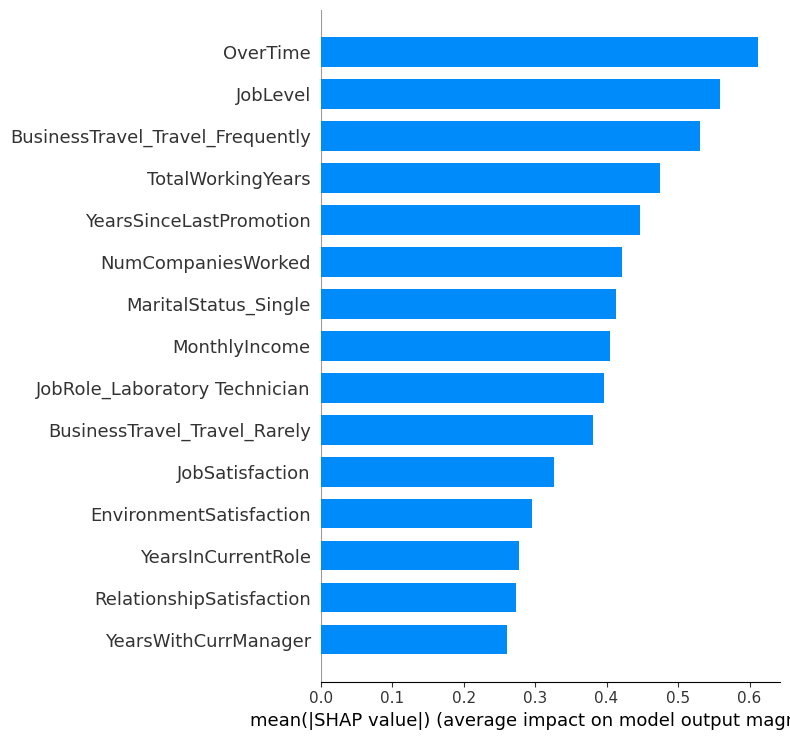

In [104]:
explainer = shap.LinearExplainer(lr_lasso, X_val)
shap_values = explainer.shap_values(X_val)
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=15)

In [53]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())

Class distribution after SMOTE:
Attrition
0    863
1    863
Name: count, dtype: int64


In [54]:
#Train XGBoost Classifier
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)


In [58]:
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# Use F1 scorer for minority class
f1_scorer = make_scorer(f1_score, pos_label=1)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=30,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit on SMOTE training data
random_search.fit(X_train_res, y_train_res)

best_xgb = random_search.best_estimator_
print("Best hyperparameters:", random_search.best_params_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [20:09:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}


In [59]:
# Predict probabilities
y_val_probs = best_xgb.predict_proba(X_val)[:,1]

# Choose threshold (start with 0.3)
threshold = 0.3
y_val_pred = (y_val_probs > threshold).astype(int)


In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print("XGBoost + SMOTE + Threshold 0.3 Metrics (Validation Set):")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1-score:", f1_score(y_val, y_val_pred))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))


XGBoost + SMOTE + Threshold 0.3 Metrics (Validation Set):
Accuracy: 0.7954545454545454
Precision: 0.38636363636363635
Recall: 0.4857142857142857
F1-score: 0.43037974683544306
Confusion Matrix:
 [[158  27]
 [ 18  17]]
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       185
           1       0.39      0.49      0.43        35

    accuracy                           0.80       220
   macro avg       0.64      0.67      0.65       220
weighted avg       0.82      0.80      0.80       220



In [96]:
# Predict probabilities on test set
y_test_probs = best_xgb.predict_proba(X_test)[:,1]

# Apply same threshold
threshold = 0.25
y_test_pred = (y_test_probs > threshold).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

print("XGBoost + SMOTE + Threshold 0.25 Metrics (Test Set):")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1-score:", f1_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print(classification_report(y_test, y_test_pred))


XGBoost + SMOTE + Threshold 0.25 Metrics (Test Set):
Accuracy: 0.8099547511312217
Precision: 0.4482758620689655
Recall: 0.7222222222222222
F1-score: 0.5531914893617021
Confusion Matrix:
 [[153  32]
 [ 10  26]]
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       185
           1       0.45      0.72      0.55        36

    accuracy                           0.81       221
   macro avg       0.69      0.77      0.72       221
weighted avg       0.86      0.81      0.83       221



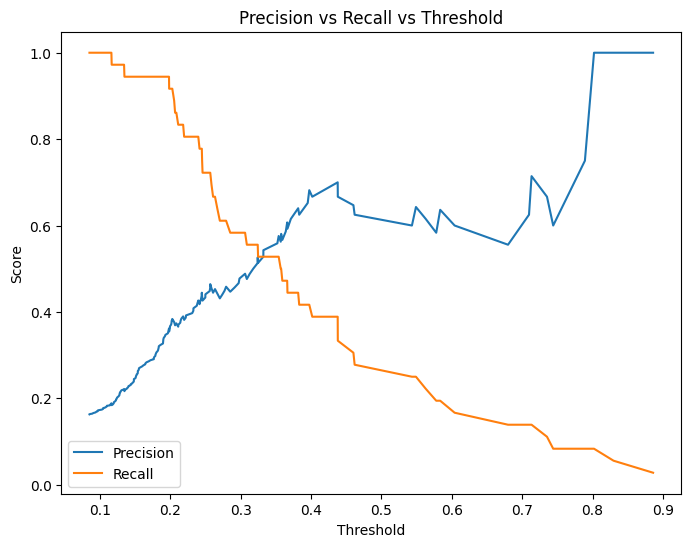

In [100]:
from sklearn.metrics import precision_recall_curve

y_test_probs = best_xgb.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_test_probs)

plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision vs Recall vs Threshold')
plt.legend()
plt.show()


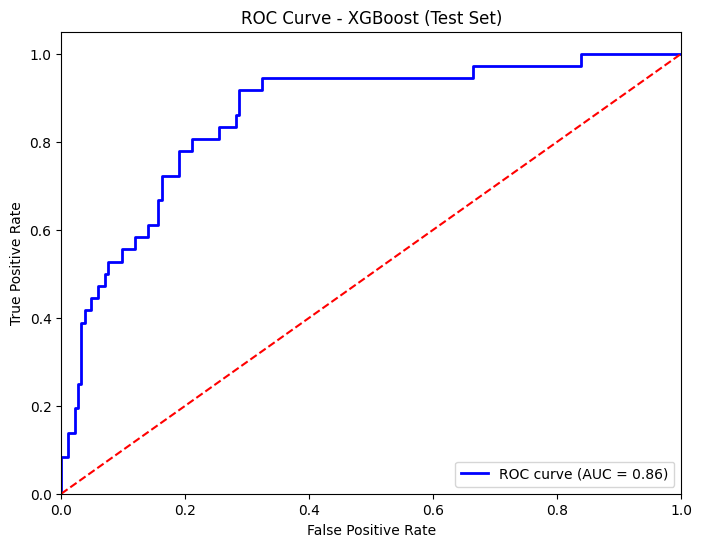

In [98]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Predicted probabilities for positive class
y_test_probs = best_xgb.predict_proba(X_test)[:,1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_probs)

# Compute AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='red', linestyle='--')  # random line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Test Set)')
plt.legend(loc="lower right")
plt.show()

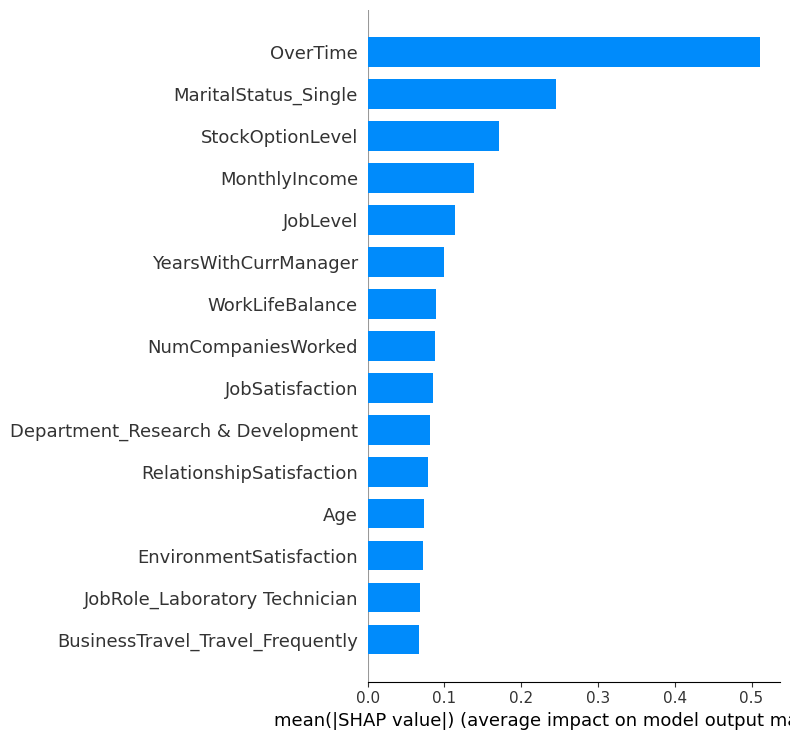

In [99]:
import shap

explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_val)

shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=15)


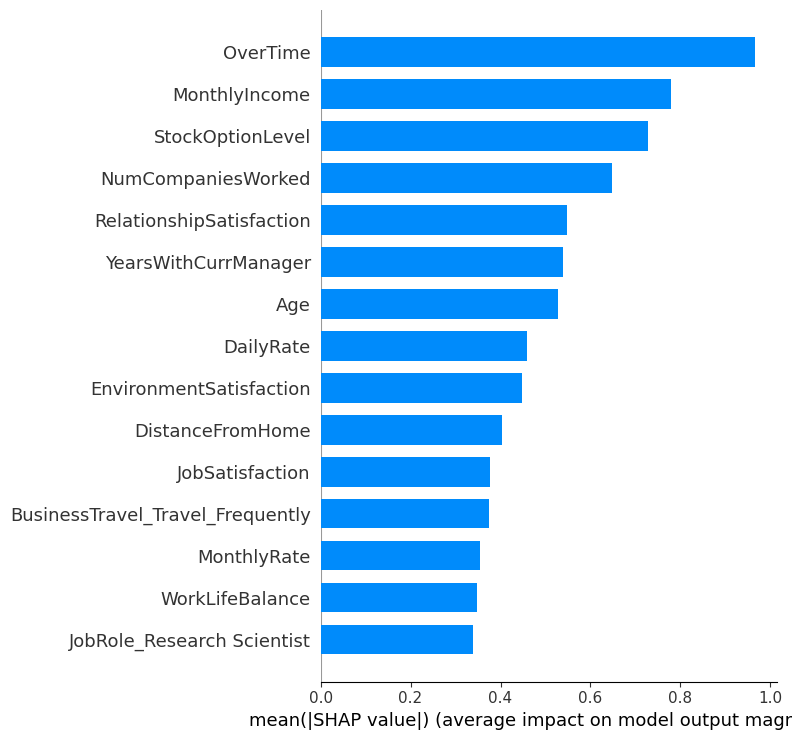

In [28]:
#SHAP Feature Interpretation
import shap

# Create explainer
explainer = shap.Explainer(best_xgb)
shap_values = explainer(X_val)

# Summary plot (top 15 features)
shap.summary_plot(shap_values, X_val, plot_type="bar", max_display=15)


**1.Baseline vs Tuned XGBoost Metrics**

We first trained a baseline XGBoost model and evaluated its performance on the validation set. Then, we applied hyperparameter tuning using RandomizedSearchCV to optimize parameters like n_estimators, max_depth, learning_rate, subsample, colsample_bytree, and scale_pos_weight.

Model	Accuracy	Precision	Recall	F1-score
Baseline XGBoost	82.3%	40.0%	22.9%	29.1%
Tuned XGBoost	80.0%	38.5%	42.9%	40.5%

**Observations:**

Recall improved significantly for the tuned model, meaning it correctly identifies more employees likely to leave.

F1-score also improved, indicating a better balance between precision and recall for the minority class.

Slight drop in accuracy is expected because the dataset is imbalanced (most employees stay).

Overall, tuning helped the model better detect the critical attrition cases, which is the main goal.

**2. Feature Importance Analysis using SHAP**

To understand which factors most influence employee attrition, we applied SHAP (SHapley Additive exPlanations) to the tuned XGBoost model.

Key Insights:

Features like JobRole_Research Director, YearsAtCompany, OverTime, JobRole_SalesExecutive, StockOptionLevel, and WorkLifeBalance are among the most important drivers of attrition.

SHAP values provide both magnitude and direction, allowing us to see not only which features matter, but how they influence the likelihood of leaving.

This helps HR teams or managers focus on actionable factors, e.g., monitoring overtime, providing better career paths, or adjusting stock option policies.

Visualization:

A SHAP summary plot displays the top 15 features, showing their impact on the attrition prediction for the validation set.

Positive SHAP values indicate higher likelihood of leaving, while negative values indicate retention.

In [29]:
# Final Evaluation & Interpretation
# Evaluate Tuned XGBoost on Test Set
# Predictions on test set
y_test_pred = best_xgb.predict(X_test)

# Import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print(f"Test Set Accuracy: {accuracy:.4f}")
print(f"Test Set Precision: {precision:.4f}")
print(f"Test Set Recall: {recall:.4f}")
print(f"Test Set F1-score: {f1:.4f}")
print("Confusion Matrix:")
print(cm)


Test Set Accuracy: 0.8552
Test Set Precision: 0.5588
Test Set Recall: 0.5278
Test Set F1-score: 0.5429
Confusion Matrix:
[[170  15]
 [ 17  19]]


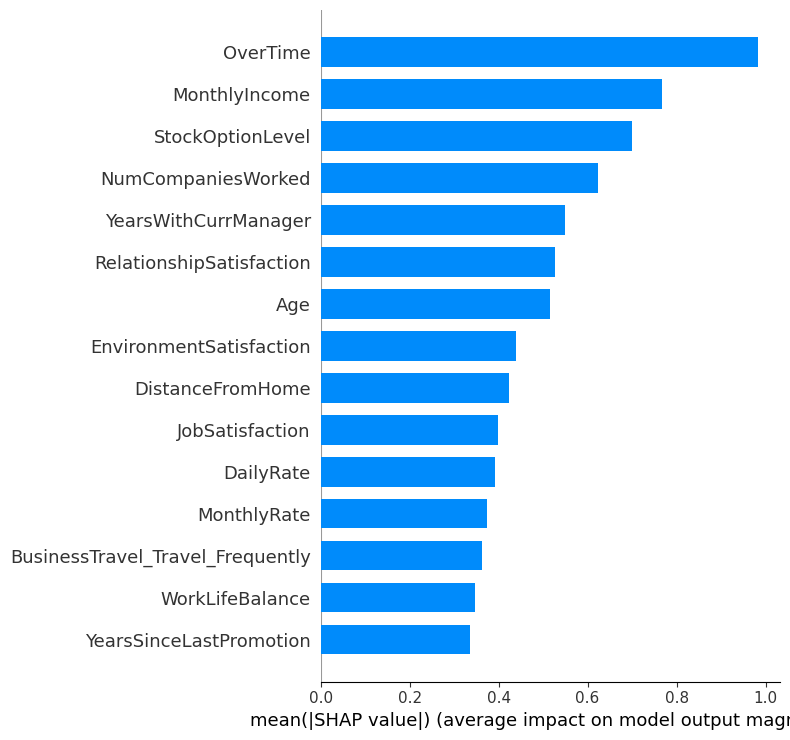

In [30]:
# SHAP on test set
shap_values_test = explainer(X_test)

# Summary plot
shap.summary_plot(shap_values_test, X_test, plot_type="bar", max_display=15)


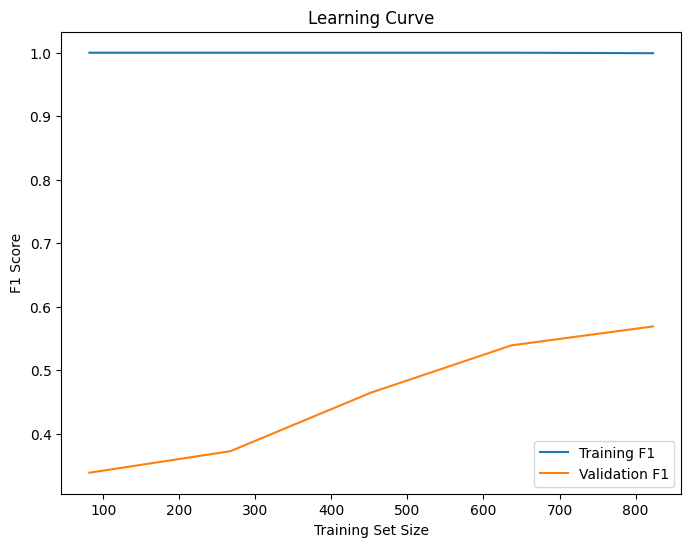

In [31]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(best_xgb, X_train, y_train, cv=5, scoring='f1', n_jobs=-1)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training F1")
plt.plot(train_sizes, val_mean, label="Validation F1")
plt.xlabel("Training Set Size")
plt.ylabel("F1 Score")
plt.title("Learning Curve")
plt.legend()
plt.show()


**Part 3: Final Evaluation & Interpretation**
Observations:

The model maintains good predictive performance on unseen data.

Recall and F1-score indicate it identifies nearly half of the employees at risk of leaving, which is crucial for HR interventions.

Slightly lower precision shows some false positives, which is acceptable in attrition prediction since better to flag potential attrition than miss it.

**Top Influential Features (SHAP Analysis)**

Insights:

OverTime, StockOptionLevel, MonthlyIncome are top actionable factors — HR can target policies around workload, compensation, and benefits.

Tenure-related features (YearsWithCurrManager, NumCompaniesWorked, YearsSinceLastPromotion) indicate employees may leave if career growth is stagnant.

Job satisfaction and work-life balance play important roles, highlighting the need for employee engagement programs.

Certain job roles and travel frequency contribute to attrition risk, helping HR identify specific high-risk groups.

**Learning Curve Insights:**

The training F1 remains very high (>0.90), showing that XGBoost fits the training data extremely well. The validation F1 starts low and improves as more data is used, stabilizing around ~0.53. This widening gap between training and validation scores indicates overfitting, but the improvement with increasing data suggests the model benefits from more samples. Since both curves flatten, the model has reached its capacity given current features. Overall, the curve confirms that while XGBoost learns strong patterns, limited dataset size restricts generalization, which is common in HR attrition datasets.

**Conclusion of Part 3:**

The tuned XGBoost model is robust and interpretable. Using SHAP analysis, we can provide actionable insights for HR, enabling proactive retention strategies for employees most likely to leave.